<a href="https://colab.research.google.com/github/oktaviacitra/classification/blob/main/VillainClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

origin_path = "/content/drive"
drive.mount(origin_path)

folder_path = origin_path + "/MyDrive/Learning Journey/Villain Data/"

Mounted at /content/drive


In [2]:
class_labels = ["Vader", "Green Goblin", "Joker", "Thanos", "Venom"]
image_files = [ (folder_path + label + "/" + label + " " + str(i) + ".jpg") for i in range(1, 21) for label in class_labels]
len(image_files)

100

In [3]:
import tensorflow
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image

def preprocessing_image(path, target):
    img = Image.open(path)

    # crop central
    width, height = img.size
    new_width = new_height = width if width > height else height
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    img = img.crop((left, top, right, bottom))

    # convert to array of rgb
    img = img.resize(target)
    img = img.convert('RGB')
    x = image.img_to_array(img)
    x = x[:, :, :3]
    x = np.true_divide(x, 255)
    return x

In [4]:
from sklearn.preprocessing import LabelEncoder

X = np.asarray([preprocessing_image(image_file, (64,64)) for image_file in image_files])

y = [ label for i in range(1, 21) for label in class_labels]
le = LabelEncoder()
le.fit(y)
y = le.transform(y)


X.shape, y.shape

((100, 64, 64, 3), (100,))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_train.shape, X_test.shape, X_val.shape

((70, 64, 64, 3), (15, 64, 64, 3), (15, 64, 64, 3))

In [7]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 36.0 MB/s 


In [8]:
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

def model_builder(hp):
  inputs = Input(shape=(64, 64, 3))
  for i in range(hp.Int('conv_layers', 1, 5)):
    x = Conv2D(filters = hp.Int("filters_" + str(i), min_value=256, max_value=1024, step = 64),
              kernel_size = hp.Int("kernel_size_" + str(i), 3, 5),
              padding="same",
              activation='relu',
              dilation_rate=2,
              kernel_initializer = "he_normal",
              kernel_regularizer=regularizers.l2(0.001),
              name="conv2d_" + str(i))(inputs)

    if hp.Choice('pooling', ['max', 'avg']) == 'max':
      x = MaxPooling2D(name="maxpool2d_" + str(i))(x)
    else:
      x = AveragePooling2D(name="averagepool2d_" + str(i))(x)

  x = BatchNormalization(name="batchnorm")(x)
  x = Dropout(0.1, name="dropout")(x)
  if hp.Choice('global_average', ['max', 'avg']) == 'max':
    x = GlobalMaxPool2D(name="globalmaxpool")(x)
  else:
    x = GlobalAveragePooling2D(name="averagepool2d")(x)
  
  x = Activation('relu', name='activation')(x)
  outputs = Dense(5, activation='softmax', name='prediction')(x)

  model = Model(inputs=inputs, outputs=outputs)

  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=learning_rate) if hp.Choice('optimizer', ['adam', 'sgd']) == 'adam' else SGD(learning_rate=learning_rate)
  
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [9]:
import keras_tuner as kt

tuner = kt.Hyperband(hypermodel = model_builder,
                             objective = 'val_loss',
                             max_epochs = 10,
                             factor = 3,
                             directory = folder_path + '/results_dir',
                             project_name = 'villain')
tuner.search_space_summary()

Search space summary
Default search space size: 7
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 64, 'sampling': None}
kernel_size_0 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': None}
pooling (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}
global_average (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

best_weight = ModelCheckpoint(folder_path + "tuner/{epoch:02d}-{val_loss:.4f}.h5",
                              monitor="val_loss",
                              mode="min",
                              save_best_only=True,
                              verbose=1)
stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=5,
             validation_data=(X_val, y_val),
             callbacks=[stop_early, best_weight],
             verbose=2)

Trial 30 Complete [00h 00m 07s]
val_loss: 3.712221622467041

Best val_loss So Far: 2.0674517154693604
Total elapsed time: 00h 01m 17s


In [11]:
from tensorflow.keras.models import load_model

model = load_model(folder_path + "tuner/01-2.0675.h5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       7168      
                                                                 
 maxpool2d_4 (MaxPooling2D)  (None, 32, 32, 256)       0         
                                                                 
 batchnorm (BatchNormalizati  (None, 32, 32, 256)      1024      
 on)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 globalmaxpool (GlobalMaxPoo  (None, 256)              0         
 ling2D)                                                     

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1),
             ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience=2, verbose=1),
             ModelCheckpoint(folder_path + "tuner/{epoch:02d}-{val_loss:.4f}.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)]
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_val, y_val), verbose=1,
                    callbacks=callbacks)

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 20.4722 - accuracy: 0.1562
Epoch 1: val_loss improved from inf to 3.32111, saving model to /content/drive/MyDrive/Learning Journey/Villain Data/tuner/01-3.3211.h5
3/3 [==============================] - 1s 128ms/step - loss: 16.9024 - accuracy: 0.2143 - val_loss: 3.3211 - val_accuracy: 0.1333 - lr: 0.0100
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 9.5127 - accuracy: 0.3125
Epoch 2: val_loss did not improve from 3.32111
3/3 [==============================] - 0s 32ms/step - loss: 8.8375 - accuracy: 0.2714 - val_loss: 3.8193 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 5.6074 - accuracy: 0.2812
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 3: val_loss did not improve from 3.32111
3/3 [==============================] - 0s 36ms/step - loss: 8.4189 - accuracy: 0.2429 - val_loss: 3.6248 - val_accuracy: 0.2000 -

In [13]:
import matplotlib.pyplot as plt

def graph_history(title, subtitle, interval):
    plt.plot(history.history[title], label = title)
    plt.plot(history.history[subtitle], label = subtitle)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.ylim(interval)
    plt.legend(loc='lower right')

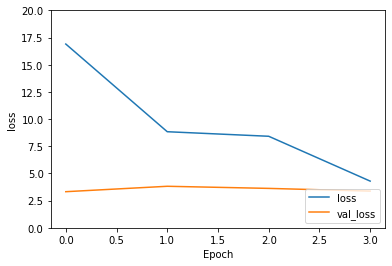

In [15]:
graph_history('loss', 'val_loss', [0.0, 20.0])

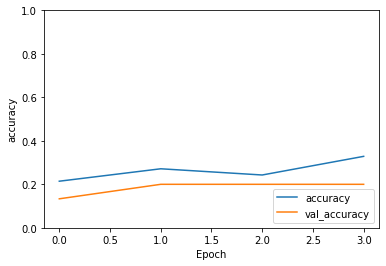

In [16]:
graph_history('accuracy', 'val_accuracy', [0.0, 1.0])

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = np.argmax(model.predict(X_test), axis=1)
print('accuracy : %.4f' % (accuracy_score(y_test, y_pred)) )
print('precision : %.4f' % (precision_score(y_test, y_pred, average='macro')) )
print('recall : %.4f' % (recall_score(y_test, y_pred, average='macro')) )
print('f1 : %.4f' % (f1_score(y_test, y_pred, average='macro')) )

accuracy : 0.2000
precision : 0.0500
recall : 0.2500
f1 : 0.0833


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


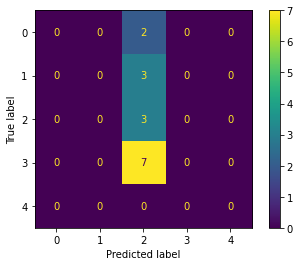

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()